In [1]:
import sys
sys.version
sys.path

['/Users/ralfschmaelzle/Documents/GITHUB/nomcomm/PAPERS_WORKING/narratives_pieman/scripts',
 '/opt/anaconda3/envs/neuroimaging/lib/python39.zip',
 '/opt/anaconda3/envs/neuroimaging/lib/python3.9',
 '/opt/anaconda3/envs/neuroimaging/lib/python3.9/lib-dynload',
 '',
 '/opt/anaconda3/envs/neuroimaging/lib/python3.9/site-packages',
 '/opt/anaconda3/envs/neuroimaging/lib/python3.9/site-packages/IPython/extensions',
 '/Users/ralfschmaelzle/.ipython']

In [2]:
import re, sys
import nilearn
from nilearn import plotting, input_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/opt/anaconda3/envs/neuroimaging/lib/python3.9/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [3]:
fmri_data = np.load('../data_pieman/fmri_data_pieman.npy')
print(fmri_data.shape)

data = fmri_data.copy()
data = np.swapaxes(data, 0,1)
data = np.swapaxes(data, 1,2)
print(data.shape)

(68, 300, 293)
(300, 293, 68)


In [4]:
import numpy as np
from scipy.spatial.distance import squareform
from scipy.stats import pearsonr, zscore
from scipy.fftpack import fft, ifft
import itertools as it
import sys


def camcan_isc(data, pairwise=False, summary_statistic=None, verbose=True):
    """Intersubject correlation
    For each voxel or ROI, compute the Pearson correlation between each
    subject's response time series and other subjects' response time series.
    If pairwise is False (default), use the leave-one-out approach, where
    correlation is computed between each subject and the average of the other
    subjects. If pairwise is True, compute correlations between all pairs of
    subjects. If summary_statistic is None, return N ISC values for N subjects
    (leave-one-out) or N(N-1)/2 ISC values for each pair of N subjects,
    corresponding to the upper triangle of the pairwise correlation matrix
    (see scipy.spatial.distance.squareform). Alternatively, supply either
    np.mean or np.median to compute summary statistic of ISCs (Fisher Z will
    be applied and inverted if using mean). Input data should be a list 
    where each item is a time-points by voxels ndarray for a given subject.
    Multiple input ndarrays must be the same shape. If a single ndarray is
    supplied, the last dimension is assumed to correspond to subjects. If 
    only two subjects are supplied, simply compute Pearson correlation
    (precludes averaging in leave-one-out approach, and does not apply
    summary statistic.) Output is an ndarray where the first dimension is
    the number of subjects or pairs and the second dimension is the number
    of voxels (or ROIs).
        
    The implementation is based on the following publication:
    
    .. [Hasson2004] "Intersubject synchronization of cortical activity 
    during natural vision.", U. Hasson, Y. Nir, I. Levy, G. Fuhrmann,
    R. Malach, 2004, Science, 303, 1634-1640.
    Parameters
    ----------
    data : list or ndarray
        fMRI data for which to compute ISC
        
    pairwise : bool, default: False
        Whether to use pairwise (True) or leave-one-out (False) approach
        
    summary_statistic : None
        Return all ISCs or collapse using np.mean or np.median
    Returns
    -------
    iscs : subjects or pairs by voxels ndarray
        ISC for each subject or pair (or summary statistic) per voxel
    """
    
    # Convert list input to 3d and check shapes
    if type(data) == list:
        data_shape = data[0].shape
        for i, d in enumerate(data):
            if d.shape != data_shape:
                raise ValueError("All ndarrays in input list "
                                 "must be the same shape!")
            if d.ndim == 1:
                data[i] = d[:, np.newaxis]
        data = np.dstack(data)

    # Convert input ndarray to 3d and check shape
    elif type(data) == np.ndarray:
        if data.ndim == 2:
            data = data[:, np.newaxis, :]            
        elif data.ndim == 3:
            pass
        else:
            raise ValueError("Input ndarray should have 2 "
                             f"or 3 dimensions (got {data.ndim})!")

    # Infer subjects, TRs, voxels and print for user to check
    n_subjects = data.shape[2]
    n_TRs = data.shape[0]
    n_voxels = data.shape[1]
    if verbose:
        print(f"Assuming {n_subjects} subjects with {n_TRs} time points "
              f"and {n_voxels} voxel(s) or ROI(s).")
    
    # Loop over each voxel or ROI
    voxel_iscs = []
    for v in np.arange(n_voxels):
        voxel_data = data[:, v, :].T
        if n_subjects == 2:
            iscs = pearsonr(voxel_data[0, :], voxel_data[1, :])[0]
            summary_statistic = None
            if verbose:
                print("Only two subjects! Simply computing Pearson correlation.")
        elif pairwise:
            iscs = squareform(np.corrcoef(voxel_data), checks=False)
        elif not pairwise:
            iscs = np.array([pearsonr(subject,
                                      np.mean(np.delete(voxel_data,
                                                        s, axis=0),
                                              axis=0))[0]
                    for s, subject in enumerate(voxel_data)])
        voxel_iscs.append(iscs)
    iscs = np.column_stack(voxel_iscs)
    
    # Summarize results (if requested)
    if summary_statistic == np.mean:
        iscs = np.tanh(summary_statistic(np.arctanh(iscs), axis=0))[np.newaxis, :]
    elif summary_statistic == np.median:    
        iscs = summary_statistic(iscs, axis=0)[np.newaxis, :]
    elif not summary_statistic:
        pass
    else:
        raise ValueError("Unrecognized summary_statistic! Use None, np.median, or np.mean.")
    return iscs


def camcan_phaseshift_isc(data, pairwise=False, summary_statistic=np.median,
                   n_shifts=1000, return_distribution=False, random_state=None):
    
    """Phase randomization for one-sample ISC test
    
    For each voxel or ROI, compute the actual ISC and p-values
    from a null distribution of ISCs where response time series
    are phase randomized prior to computing ISC. If pairwise,
    apply phase randomization to each subject and compute pairwise
    ISCs. If leave-one-out approach is used (pairwise=False), only
    apply phase randomization to the left-out subject in each iteration
    of the leave-one-out procedure. Input data should be a list where
    each item is a time-points by voxels ndarray for a given subject.
    Multiple input ndarrays must be the same shape. If a single ndarray is
    supplied, the last dimension is assumed to correspond to subjects.
    Returns the observed ISC and p-values (two-tailed test). Optionally
    returns the null distribution of ISCs computed on phase-randomized
    data.
    
    This implementation is based on the following publications:
    .. [Lerner2011] "Topographic mapping of a hierarchy of temporal
    receptive windows using a narrated story.", Y. Lerner, C. J. Honey,
    L. J. Silbert, U. Hasson, 2011, Journal of Neuroscience, 31, 2906-2915.
    .. [Simony2016] "Dynamic reconfiguration of the default mode network
    during narrative comprehension.", E. Simony, C. J. Honey, J. Chen, O.
    Lositsky, Y. Yeshurun, A. Wiesel, U. Hasson, 2016, Nature Communications,
    7, 12141.
    Parameters
    ----------
    data : list or dict, time series data for multiple subjects
        List or dictionary of response time series for multiple subjects
    pairwise : bool, default:False
        Indicator of pairwise or leave-one-out, should match iscs variable
    summary_statistic : numpy function, default:np.median
        Summary statistic, either np.median (default) or np.mean
        
    n_shifts : int, default:1000
        Number of randomly shifted samples
        
    return_distribution : bool, default:False
        Optionally return the bootstrap distribution of summary statistics
        
    random_state = int, None, or np.random.RandomState, default:None
        Initial random seed
    Returns
    -------
    observed : float, observed ISC (without time-shifting)
        Actual ISCs
    p : float, p-value
        p-value based on time-shifting randomization test
        
    distribution : ndarray, time-shifts by voxels (optional)
        Time-shifted null distribution if return_bootstrap=True
    """

    # Convert list input to 3d and check shapes
    if type(data) == list:
        data_shape = data[0].shape
        for i, d in enumerate(data):
            if d.shape != data_shape:
                raise ValueError("All ndarrays in input list "
                                 "must be the same shape!")
            if d.ndim == 1:
                data[i] = d[:, np.newaxis]
        data = np.dstack(data)

    # Convert input ndarray to 3d and check shape
    elif type(data) == np.ndarray:
        if data.ndim == 2:
            data = data[:, np.newaxis, :]            
        elif data.ndim == 3:
            pass
        else:
            raise ValueError("Input ndarray should have 2 "
                             f"or 3 dimensions (got {data.ndim})!")

    # Infer subjects, TRs, voxels and print for user to check
    n_subjects = data.shape[2]
    n_TRs = data.shape[0]
    n_voxels = data.shape[1]
    
    # Get actual observed ISC
    observed = camcan_isc(data, pairwise=pairwise, summary_statistic=summary_statistic, verbose=False)
    
    # Iterate through randomized shifts to create null distribution
    distribution = []
    for i in np.arange(n_shifts):
        
        # Random seed to be deterministically re-randomized at each iteration
        if isinstance(random_state, np.random.RandomState):
            prng = random_state
        else:
            prng = np.random.RandomState(random_state)
            
        # Get randomized phase shifts
        if data.shape[0] % 2 == 0:
            # Why are we indexing from 1 not zero here? Vector is n_TRs / -1 long?
            pos_freq = np.arange(1, data.shape[0] // 2)
            neg_freq = np.arange(data.shape[0] - 1, data.shape[0] // 2, -1)
        else:
            pos_freq = np.arange(1, (data.shape[0] - 1) // 2 + 1)
            neg_freq = np.arange(data.shape[0] - 1, (data.shape[0] - 1) // 2, -1)

        phase_shifts = prng.rand(len(pos_freq), 1, n_subjects) * 2 * np.math.pi
        
        # In pairwise approach, apply all shifts then compute pairwise ISCs
        if pairwise:
        
            # Fast Fourier transform along time dimension of data
            fft_data = fft(data, axis=0)

            # Shift pos and neg frequencies symmetrically, to keep signal real
            fft_data[pos_freq, :, :] *= np.exp(1j * phase_shifts)
            fft_data[neg_freq, :, :] *= np.exp(-1j * phase_shifts)

            # Inverse FFT to put data back in time domain for ISC
            shifted_data = np.real(ifft(fft_data, axis=0))

            # Compute null ISC on shifted data for pairwise approach
            shifted_isc = camcan_isc(shifted_data, pairwise=True,
                              summary_statistic=summary_statistic, verbose=False)
        
        # In leave-one-out, apply shift only to each left-out participant
        elif not pairwise:
            
            # Roll subject axis in phaseshifts for loop
            phase_shifts = np.rollaxis(phase_shifts, 2, 0)
            
            shifted_isc = []
            for s, shift in enumerate(phase_shifts):
                
                # Apply FFT to left-out subject
                fft_subject = fft(data[:, :, s], axis=0)
                
                # Shift pos and neg frequencies symmetrically, to keep signal real
                fft_subject[pos_freq, :] *= np.exp(1j * shift)
                fft_subject[neg_freq, :] *= np.exp(-1j * shift)

                # Inverse FFT to put data back in time domain for ISC
                shifted_subject = np.real(ifft(fft_subject, axis=0))

                # Compute ISC of shifted left-out subject against mean of N-1 subjects
                nonshifted_mean = np.mean(np.delete(data, s, 2), axis=2)
                loo_isc = camcan_isc(np.dstack((shifted_subject, nonshifted_mean)), pairwise=False,
                              summary_statistic=None, verbose=False)
                shifted_isc.append(loo_isc)
                
            # Get summary statistics across left-out subjects
            if summary_statistic == np.mean:
                shifted_isc = np.tanh(np.mean(np.arctanh(np.dstack(shifted_isc)), axis=2))
            elif summary_statistic == np.median:
                shifted_isc = np.median(np.dstack(shifted_isc), axis=2)
                
        distribution.append(shifted_isc)
        
        # Update random state for next iteration
        random_state = np.random.RandomState(prng.randint(0, 2**32 - 1))
        
    # Convert distribution to numpy array
    distribution = np.vstack(distribution)
    assert distribution.shape == (n_shifts, n_voxels)

    # Get p-value for actual median from shifted distribution
    p = ((np.sum(np.abs(distribution) >= np.abs(observed), axis=0) + 1) /
          float((len(distribution) + 1)))[np.newaxis, :]
    
    if return_distribution:
        return observed, p, distribution
    elif not return_distribution:
        return observed, p

In [5]:
import os
os.getcwd()

'/Users/ralfschmaelzle/Documents/GITHUB/nomcomm/PAPERS_WORKING/narratives_pieman/scripts'

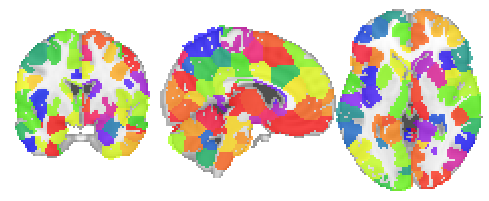

In [6]:
shen_file       = '../data_pieman/shen_2mm_268_parcellation.nii'

nilearn.plotting.plot_roi(shen_file, 
                  annotate = False, 
                  cut_coords = (5,0,0),
                  cmap = 'prism',
                  draw_cross = False, 
                  #title= 'Shen-268-node parcellation',
                 );
shen_masker = nilearn.input_data.NiftiLabelsMasker(labels_img=shen_file);

sample_file = '../data_pieman/func.nii'
shen_masker.fit_transform(sample_file);

In [7]:
ISC = camcan_isc(data, pairwise=True, summary_statistic = np.mean, verbose=False)
ISC.shape

ISC[np.isnan(ISC)] = 0

#alpha = .05
# Get q-values (i.e., FDR-controlled p-values) using statsmodels
#q = multipletests(p[0, :], method='fdr_by')[1]
#corrected = q[np.newaxis, :] < alpha
#ISC[corrected == False] = 0

'''f = plt.figure(figsize=(14,4));
ax1 = f.add_subplot(111)

res_img = shen_masker.inverse_transform(ISC);
nilearn.plotting.plot_stat_map(  nilearn.image.index_img(res_img,0), 
                                 threshold = 0.0, 
                                 #vmax = 0.7, 
                                 draw_cross = True,
                                 display_mode = 'x',
                                 cut_coords = [-50, -30, -10, 10,30,50],
                                 annotate = True,
                                 title = 'Pieman',
                                 axes = ax1);
plt.show()'''

/opt/anaconda3/envs/neuroimaging/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/envs/neuroimaging/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


"f = plt.figure(figsize=(14,4));\nax1 = f.add_subplot(111)\n\nres_img = shen_masker.inverse_transform(ISC);\nnilearn.plotting.plot_stat_map(  nilearn.image.index_img(res_img,0), \n                                 threshold = 0.0, \n                                 #vmax = 0.7, \n                                 draw_cross = True,\n                                 display_mode = 'x',\n                                 cut_coords = [-50, -30, -10, 10,30,50],\n                                 annotate = True,\n                                 title = 'Pieman',\n                                 axes = ax1);\nplt.show()"

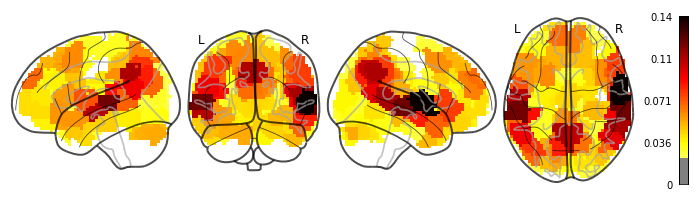

In [8]:
res_img = shen_masker.inverse_transform(ISC[:268]);

plotting.plot_glass_brain( nilearn.image.index_img(res_img,0) ,
                          display_mode = 'lyrz',
                          colorbar = 'True',
                         )

In [9]:
#res_img = pauli_masker.inverse_transform(ISC[268:283]);

#plotting.plot_glass_brain( nilearn.image.index_img(res_img,0) ,
#                          display_mode = 'lyrz',
#                          colorbar = 'True',
#                         )

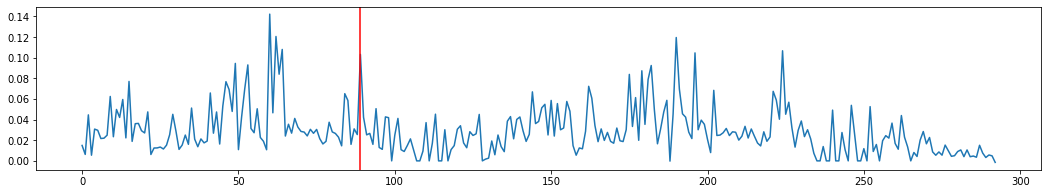

In [10]:
plt.figure(figsize = (18,3))
plt.plot(ISC.T);
plt.axvline(89, color = 'red')

0.30197239380113733


"roi_vec = np.zeros((1,268))\nroi_vec[0,curr_roi] = 1\nroi_img = shen_masker.inverse_transform(roi_vec);\nplotting.plot_glass_brain( nilearn.image.index_img(roi_img,0) ,\n                          display_mode = 'x',\n                          colorbar = 'True',\n                         ) #"

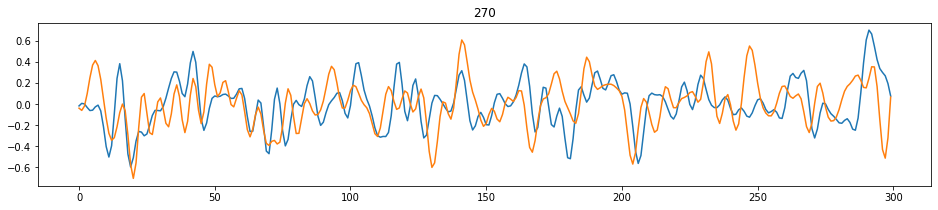

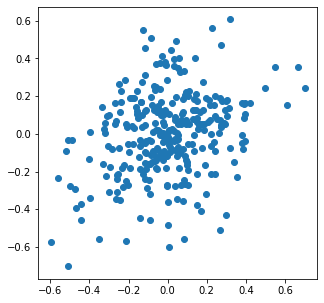

In [11]:
m1 = np.mean(data[:,:, :34], axis =2)
m2 = np.mean(data[:,:, 34:], axis =2)

curr_roi = 270

plt.figure(figsize = (16,3))

plt.plot(m1[:,curr_roi]);
plt.plot(m2[:,curr_roi]);
plt.title(str(curr_roi))
print(np.corrcoef(m1[:,curr_roi], m2[:,curr_roi])[0,1])

plt.figure(figsize = (5,5))
plt.scatter(m1[:,curr_roi],
           m2[:,curr_roi])

'''roi_vec = np.zeros((1,268))
roi_vec[0,curr_roi] = 1
roi_img = shen_masker.inverse_transform(roi_vec);
plotting.plot_glass_brain( nilearn.image.index_img(roi_img,0) ,
                          display_mode = 'x',
                          colorbar = 'True',
                         ) #'''

In [19]:
#Pauli
subcortex = nilearn.datasets.fetch_atlas_pauli_2017()
pauli_masker = input_data.NiftiMapsMasker(subcortex.maps[2]);
sample_file = '../data_pieman/func.nii'
#pauli_masker.fit_transform(sample_file);

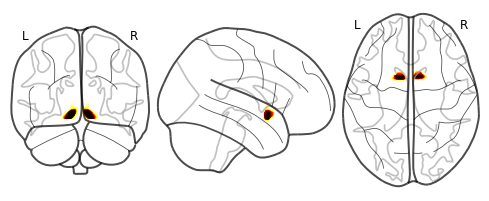

In [20]:
plotting.plot_glass_brain(nilearn.image.index_img(subcortex.maps, 2))